In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import string
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from nltk.probability import FreqDist
from wordcloud import WordCloud

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# First look at the data

In [2]:
df = pd.read_json('data/Graduate - HEADLINES dataset (2019-06).json', lines=True)
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [3]:
df.shape

(26709, 2)

In [4]:
df.isna().any()

headline        False
is_sarcastic    False
dtype: bool

In [5]:
df.dtypes

headline        object
is_sarcastic     int64
dtype: object

In [6]:
df['headline'] = df['headline'].astype('string')

In [7]:
df['headline'].str.len().mean()

60.910591935302705

In [8]:
df['headline'].str.len().min()

7

Let's take a look at the shortest headline that we have. It is not sarcastic.

In [9]:
df.loc[df['headline'].str.len() == 7]

,headline,is_sarcastic
20551,bye bye,0


In [10]:
df['headline'].str.len().max()

254

In the opposite, the longest one is sarcastic.

In [11]:
df.loc[df['headline'].str.len() == 254]

,headline,is_sarcastic
19868,"maya angelou, poet, author, civil rights activ...",1


In [12]:
df.loc[df['headline'].str.len() == 254, 'headline'].values

<StringArray>
['maya angelou, poet, author, civil rights activist, and—holy cow—tony award–nominated actress, college professor, magazine editor, streetcar conductor—really? streetcar conductor? wow—calypso singer, nightclub performer, and foreign journalist, dead at 86']
Length: 1, dtype: string

The classes are approximately balanced

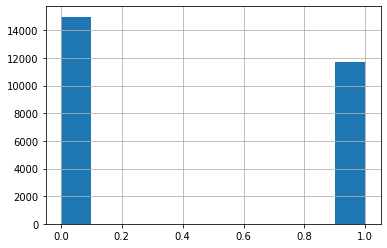

In [13]:
df['is_sarcastic'].hist();

# Preprocessing

The internet is full of emoticons. Maybe it would be a good idea to leave them? Sarcastic headlines may contain more of them than non-sarcastic headlines.

In [14]:
RE_EMOTICONS = re.compile("(:-?\))|(:p)|(:d+)|(:-?\()|(:/)|(;-?\))|(<3)|(=\))|(\)-?:)|(:'\()|(8\))")

for i in range(len(df)):
    match = RE_EMOTICONS.search(df.loc[i, 'headline'])
    if match is not None:
        print(f'Emoticon found: {match[0]}, is its headline sarcastic? {df.loc[i, "is_sarcastic"]}')

Emoticon found: ):, is its headline sarcastic? 0
Emoticon found: ):, is its headline sarcastic? 0


It turns out there is very few of them, so I will get read of them, not to make my data noisy.

I will also take a look at most popular tokens that appear in the headlines

In [15]:
tokens = []
for i in range(len(df)):
    tokens += word_tokenize(df.loc[i, 'headline'])

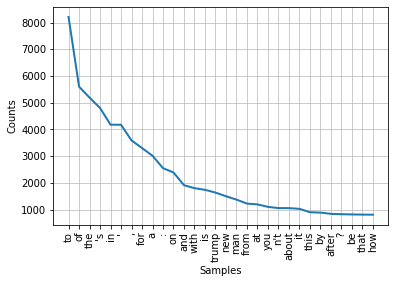

In [16]:
freq_dist = FreqDist(tokens)
freq_dist.plot(30)
plt.show()

It is not a suprise that some stop words appear in the chart, but there are also some other words, like "Trump" or "man". I will compare the results with the one I obtain after some preprocessing. 

In particular, I will:
- remove punctuation, stopwords and unnecessary spaces
- lowercase the words
- tokenize them
- lemmatize them based on the context in which they appear. It is achieved by tagging part of speech using WordNet, a language database that describes the language structure

In [17]:
class Preprocessor(BaseEstimator, TransformerMixin):
    """Scikit-learn compatible tranformer, implementing text preprocessing using nltk.
        Each word in the headline is tokenized and lemmatized based on its context.
        Stop words are removed. Digits can also be removed.
        
        Arguments
        ---------
            remove_digits : bool (default=False), whenever to remove digits from text
            join_tokens : bool (default=True), whenever to join all the tokens to single string
    
    """
    
    def __init__(self, remove_digits=False, join_tokens=True, remove_stop_words=True):
            self.remove_digits=remove_digits
            self.join_tokens = join_tokens
            self.remove_stop_words = remove_stop_words
            self.stop_words = set(sw.words('english'))
            self.lemmatizer = WordNetLemmatizer()
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [self.tokenize(headline) for headline in X]
    
    def tokenize(self, headline):
        tokens = []
        for token, tag in pos_tag(wordpunct_tokenize(headline)):
            token = self.normalize(token)
            
            if self.remove_stop_words:
                if token in self.stop_words:
                    continue
                
            if len(token) <= 1:
                continue
                                  
            lemmatized = self.lemmatize(token, tag)
            tokens.append(lemmatized)
            
        if self.join_tokens:
            return ' '.join(tokens)
        else: 
            return tokens
        
    def normalize(self, text):
        if self.remove_digits:
            text = re.sub(r'\d+', '', text)
        text = self.remove_punctuation(text)
        text = text.strip().lower()
        return text
    
    def remove_punctuation(self, text):
        text = ''.join([c for c in text if c not in string.punctuation ])
        return text
                                  
    def lemmatize(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)
        

In [18]:
tokens_preprocessed = []
preprocessor = Preprocessor(join_tokens=False)
for i in range(len(df)):
    preprocessed_token = preprocessor.tokenize(df.loc[i, 'headline'])
    tokens_preprocessed += preprocessed_token

After applying preprocessing steps I get much more meaningful results. This time "Trump" tops the list of most frequent words. Politics seems really popular topic of the headlines, what is not a suprise. One can find "Obama", "american", "nation" at the list too.

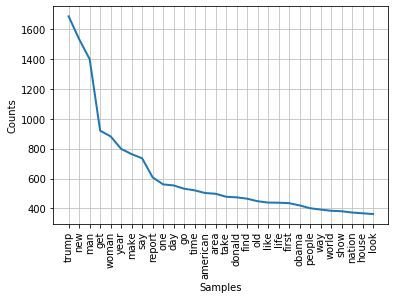

In [19]:
freq_dist_preprocessed = FreqDist(tokens_preprocessed)
freq_dist_preprocessed.plot(30)
plt.show()

In [20]:
def plot_wordcloud(wordcloud):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

What also helps us to understand the text data we are working with are wordclouds

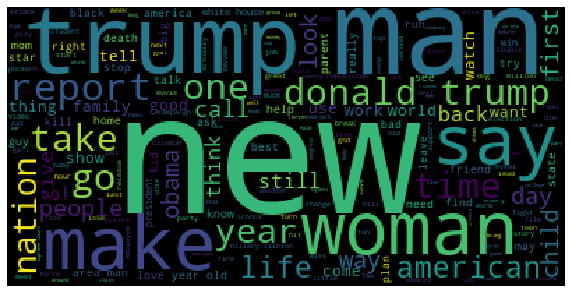

In [21]:
wordcloud = WordCloud().generate(' '.join(tokens_preprocessed))
plot_wordcloud(wordcloud)

Let's take a look at a few of the headlines itself

In [22]:
preprocessed = Preprocessor().fit_transform(df['headline'], df['is_sarcastic'])
preprocessed[:5]

['former versace store clerk sue secret black code minority shopper',
 'roseanne revival catch thorny political mood good bad',
 'mom start fear son web series closest thing grandchild',
 'boehner want wife listen come alternative debt reduction idea',
 'rowling wish snape happy birthday magical way']

# Classification

For my classification model, I will try logistic regression first. It is know to perform well on simple NLP tasks. With little parameter tuning we can get a decent result.

In [23]:
df_train_test = df.copy()
y, X = df['is_sarcastic'], df['headline']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = Pipeline(steps=[
    ('preprocessor', Preprocessor()),
    ('tf_idf', TfidfVectorizer()),
    ('model', LogisticRegression(random_state=42))
])

model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'Logistic regression accuracy: {round(accuracy_score(y_test, y_pred), 3)}')

Logistic regression accuracy: 0.786


I've also tried how the model works with larger vocabulary, without removing stop words. It turns out they are not always only noise, our model performs better now!

In [24]:
model = Pipeline(steps=[
    ('preprocessor', Preprocessor(remove_stop_words=False)),
    ('tf_idf', TfidfVectorizer()),
    ('model', LogisticRegression(random_state=42))
])

model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)
print(f'Logistic regression without removig stop words accuracy: {round(accuracy_score(y_test, y_pred), 3)}')

Logistic regression without removig stop words accuracy: 0.835


We can try to improve classification result by parameter tuning. I will try different values for regularization term.

In [25]:
logistic = LogisticRegression(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', Preprocessor(remove_stop_words=False)),
    ('tf_idf', TfidfVectorizer()),
    ('logistic', logistic)
])

params = {
    'logistic__C': [0.1, 0.2, 0.5, 1.0, 2.0]
}

search = GridSearchCV(pipeline, param_grid=params)
search = search.fit(X_train, y_train)
print(f'Best CV score: {search.best_score_}')

y_pred = search.predict(X_test)
print(f'Fine-tuned logistic regression accuracy: {round(accuracy_score(y_test, y_pred), 3)}')

Best CV score: 0.8253637141634574
Fine-tuned logistic regression accuracy: 0.838


We achieved slightly better result using less regularization. The results in the table clearly indicates that the less regularization, the betted the model performed.

In [26]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,10.219396,0.048036,5.186730,0.039849,0.1,{'logistic__C': 0.1},0.789507,0.778562,0.786712,0.784927,0.004643,5
1,10.221158,0.054749,5.163919,0.008560,0.2,{'logistic__C': 0.2},0.811648,0.794769,0.801476,0.802632,0.006939,4
2,10.325958,0.135681,5.502717,0.573040,0.5,{'logistic__C': 0.5},0.822236,0.807445,0.817686,0.815789,0.006186,3
3,11.199099,1.197566,5.583771,0.632789,1,{'logistic__C': 1.0},0.828814,0.815469,0.822821,0.822368,0.005458,2
4,12.304077,1.595072,5.687846,0.334626,2,{'logistic__C': 2.0},0.832504,0.819320,0.824266,0.825364,0.005439,1


We can check which words got the biggest coefficients

In [27]:
pd.DataFrame(search.best_estimator_['logistic'].coef_[0], 
             columns=['coefficient'],
             index=search.best_estimator_['tf_idf'].get_feature_names()).sort_values(by='coefficient', ascending=False).T

,area,nation,man,report,fuck,local,of,study,only,shit,...,my,donald,be,how,why,an,your,trump,and,the
coefficient,7.748933,7.719762,5.722104,5.233366,4.645262,4.294474,4.256654,4.037606,3.838484,3.819766,...,-4.420514,-4.767089,-5.105228,-5.11792,-5.184436,-5.199974,-5.693388,-6.769366,-7.635494,-11.624092


I've also tried removing digits in the headlines, but it doesn't have much effect on classification.

In [29]:
model = Pipeline(steps=[
    ('preprocessor', Preprocessor(remove_stop_words=False, remove_digits=True)),
    ('tf_idf', TfidfVectorizer()),
    ('model', LogisticRegression(C=2, random_state=42))
])

model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'Logistic regression accuracy with no stop words and no digits: {round(accuracy_score(y_test, y_pred), 3)}')

Logistic regression accuracy with no stop words and no digits: 0.837


I've also tried some other models: SVM and XGboost, but they give worse results.

In [30]:
svm_pipeline = Pipeline(steps=[
    ('preprocessor', Preprocessor(remove_stop_words=False)),
    ('tf_idf', TfidfVectorizer()),
    ('svm', SVC(random_state=42))
])

params = {
    'svm__C': [0.1, 0.2, 0.5, 1.0, 1.5, 2.0]
}

svm_search = GridSearchCV(svm_pipeline, param_grid=params)

svm_classifier = svm_search.fit(X_train, y_train)
svm_pred = svm_classifier.predict(X_test)
print(f'SVM accuracy: {round(accuracy_score(y_test, svm_pred), 3)}')

SVM accuracy: 0.555


In [31]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', Preprocessor(remove_stop_words=False)),
    ('tf_idf', TfidfVectorizer()),
    ('xgb', xgb.XGBClassifier(random_state=4))
])

params = {
    'xgb__max_depth': [3, 5, 7]
}

xgb_search = GridSearchCV(xgb_pipeline, param_grid=params)

xgb_classifier = xgb_search.fit(X_train, y_train)
xgb_pred = xgb_classifier.predict(X_test)
print(f'XGBoost accuracy: {round(accuracy_score(y_test, xgb_pred), 3)}')

XGBoost accuracy: 0.774
